# Project 2

This project is my first attempt at building a model to make predictions for a kaggle competition. This project will follow the general data science process, as we go through each step it will be labeled in the notebook below.

# Step 1: Define the Problem

The website Zillow wants to create a "market value" tool that will allow customers using their site to see an estimated price for any home they list on the site. This tool should be able to generalize to all houses within the city of Ames, Iowa. 

# Step 2: Gather data

Data was provided for this project, in the form of a .csv file. The csv file contained information on approximately 2,000 houses that were sold between 2005 and 2010 in Ames, with 80 features given for each sale.

# Step 3: Exploratory Data Analysis

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from functools import reduce
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# Read in original data and save it to houses. Make a copy df that will be manipulated slightly differently
houses = pd.read_csv('../Data/train.csv')
df = houses.copy()

# Read in test data and save it to houses_holdout. Make a copy test_data that will be manipulated slightly differently
houses_holdout = pd.read_csv('../Data/test.csv')
test_data = houses_holdout.copy()

In [3]:
# Find number of rows and columns using df.shape
df.shape, test_data.shape

((2051, 81), (879, 80))

This data set has 2,051 rows, and 81 columns. Each row represents one house that was sold, while each column represents one feature, or one piece of information about the specific house that was sold

In [4]:
# Investigate first 5 rows using df.head()
df.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour    ...     Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl    ...                0         0     NaN   NaN   
1       IR1          Lvl    ...                0         0     NaN   NaN   
2       Reg          Lvl    ...                0         0     NaN   NaN   
3       Reg          Lvl    ...                0         0     NaN   NaN   
4       IR1          Lvl    ...                0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

Each row has an absolutely massive amount of information. Before moving forward, we need to determine what the data type of each column is, and how many null values are present in each column

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

There are a total of 11 columns stored as floats, 28 stored as integers, and 42 stored as objects. Before doing any modeling, all data that will be used in the model must be changed to numeric

In [6]:
df.describe()

Id           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2051.000000  2.051000e+03  2051.000000   1721.000000    2051.000000   
mean   1474.033642  7.135900e+08    57.008776     69.055200   10065.208191   
std     843.980841  1.886918e+08    42.824223     23.260653    6742.488909   
min       1.000000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     753.500000  5.284581e+08    20.000000     58.000000    7500.000000   
50%    1486.000000  5.354532e+08    50.000000     68.000000    9430.000000   
75%    2198.000000  9.071801e+08    70.000000     80.000000   11513.500000   
max    2930.000000  9.241520e+08   190.000000    313.000000  159000.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2051.000000   2051.000000  2051.000000     2051.000000   2029.000000   
mean       6.112140      5.562165  1971.708922     1984.190151     99.695909   
std        1.426271      1.104497    30.177889       21.036250    174.963129   
min        1.000000      1.000000  1872.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1953.500000     1964.500000      0.000000   
50%        6.000000      5.000000  1974.000000     1993.000000      0.000000   
75%        7.000000      6.000000  2001.000000     2004.000000    161.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1600.000000   

           ...        Wood Deck SF  Open Porch SF  Enclosed Porch  \
count      ...         2051.000000    2051.000000     2051.000000   
mean       ...           93.833740      47.556802       22.571916   
std        ...          128.549416      66.747241       59.845110   
min        ...            0.000000       0.000000        0.000000   
25%        ...            0.000000       0.000000        0.000000   
50%        ...            0.000000      27.000000        0.000000   
75%        ...          168.000000      70.000000        0.000000   
max        ...         1424.000000     547.000000      432.000000   

        3Ssn Porch  Screen Porch    Pool Area      Misc Val      Mo Sold  \
count  2051.000000   2051.000000  2051.000000   2051.000000  2051.000000   
mean      2.591419     16.511458     2.397855     51.574354     6.219893   
std      25.229615     57.374204    37.782570    573.393985     2.744736   
min       0.000000      0.000000     0.000000      0.000000     1.000000   
25%       0.000000      0.000000     0.000000      0.000000     4.000000   
50%       0.000000      0.000000     0.000000      0.000000     6.000000   
75%       0.000000      0.000000     0.000000      0.000000     8.000000   
max     508.000000    490.000000   800.000000  17000.000000    12.000000   

           Yr Sold      SalePrice  
count  2051.000000    2051.000000  
mean   2007.775719  181469.701609  
std       1.312014   79258.659352  
min    2006.000000   12789.000000  
25%    2007.000000  129825.000000  
50%    2008.000000  162500.000000  
75%    2009.000000  214000.000000  
max    2010.000000  611657.000000  

[8 rows x 39 columns]

In [7]:
df['Garage Yr Blt'].sort_values(ascending=False).head()

1699    2207.0
144     2010.0
1241    2010.0
589     2009.0
1796    2009.0
Name: Garage Yr Blt, dtype: float64

Clearly there was a mistake in data entry for row 1699, as a garage could not have been built in 2207. I assume this was meant to be the year 2007 and correct it in the cell below.

In [8]:
df.loc[1699, 'Garage Yr Blt'] = 2007
df['Garage Yr Blt'].sort_values(ascending=False).head()

144     2010.0
1241    2010.0
589     2009.0
1796    2009.0
1732    2009.0
Name: Garage Yr Blt, dtype: float64

Next, I will investigate the number of null values found in both the training and testing data

In [9]:
# Find all columns with null values in df and sort in descending order
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Yr Blt      114
Garage Cond        114
Garage Qual        114
Garage Finish      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Cond           55
Bsmt Qual           55
BsmtFin Type 1      55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Garage Area          1
Total Bsmt SF        1
dtype: int64

In [10]:
# Find all columns with null values in test_data and sort in descending order
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Pool QC           875
Misc Feature      838
Alley             821
Fence             707
Fireplace Qu      422
Lot Frontage      160
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Garage Type        44
BsmtFin Type 2     25
BsmtFin Type 1     25
Bsmt Exposure      25
Bsmt Cond          25
Bsmt Qual          25
Mas Vnr Area        1
Mas Vnr Type        1
Electrical          1
dtype: int64

There are two features that have null values for over 95% of the data. These are:
- Pool QC (99.5% null for both train and test)
- Misc Feature (96.8% null for train, 95.3% null for test)

Because of the high number of null values, I will drop these columns from the data set. These features should still be accounted for by the model due to the presence of highly related features.
- `Pool QC` is related to `Pool Area`
- `Misc Feature` is related to `Misc Val`

In [11]:
df.drop(['Pool QC', 'Misc Feature'], axis=1, inplace=True)
test_data.drop(['Pool QC', 'Misc Feature'], axis=1, inplace=True)

## Data Cleaning

In [12]:
# Create function to find columns that contain a specific string
def col_finder(df, conditional_str):
    cols = [col for col in df.columns if conditional_str in col]
    return cols

I have created 2 different versions of the train/test data sets. The first, `df` and `test_data` will be manipulated to run at an optimized pace, while the second, `houses` and `houses_holdout` will try to include all data to see if the extra features make this version more accurate

For `df` and `test_data` map all of the rating columns to numerical values, then dummy all remaining categorical variables

In [13]:
rating_dict = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1, 'NA':0}

# Find all columns that use the rating system Ex, Gd, TA, Fa, Po
rating_cols = [col for col in df.columns if df[col].sort_values().iloc[0] == 'Ex']

# Remap using the dictionary created above
for col in rating_cols:
    df[col] = df[col].fillna('NA')
    df[col] = df[col].map(rating_dict)
    test_data[col] = test_data[col].fillna('NA')
    test_data[col] = test_data[col].map(rating_dict)

In [14]:
yes_no_dict = {'Y':1, 'N':0}
# Remap using the dictionary created above
df['Central Air'] = df['Central Air'].map(yes_no_dict)

test_data['Central Air'] = test_data['Central Air'].map(yes_no_dict)

In [15]:
dummies = ['Alley', 'Garage Finish', 'Garage Type', 'Bldg Type', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fence',
           'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Heating', 'House Style', 'Land Contour', 'Land Slope',
           'Lot Config', 'Lot Shape', 'Mas Vnr Type', 'MS SubClass', 'MS Zoning', 'Neighborhood',
           'Roof Matl', 'Roof Style', 'Street', 'Utilities', 'Condition 1', 'Condition 2', 'Bsmt Exposure',
           'Electrical', 'Functional', 'Paved Drive', 'Sale Type', 'Mo Sold', 'Yr Sold']

In [16]:
for col in dummies:
    df[col] = df[col].fillna('NA')
    test_data[col] = test_data[col].fillna('NA')
    train_vals = sorted(df[col].unique().tolist())
    test_vals = sorted(test_data[col].unique().tolist())
    total_vals = set(train_vals + test_vals)
    df[col] = pd.Categorical(df[col], categories=total_vals)
    test_data[col] = pd.Categorical(test_data[col], categories=total_vals)

In [17]:
df = pd.get_dummies(df, columns=dummies, drop_first=True)
test_data = pd.get_dummies(test_data, columns=dummies, drop_first=True)

For `houses` and `houses_holdout`, only map `Central Air` feature to 1's and 0's and dummy all variables including those columns with ratings

In [18]:
houses['Central Air'] = houses['Central Air'].map(yes_no_dict)

houses_holdout['Central Air'] = houses_holdout['Central Air'].map(yes_no_dict)

In [19]:
dummy_all = list(set(rating_cols + dummies))
dummy_all += ['Misc Feature', 'Pool QC']

for col in dummy_all:
    houses[col] = houses[col].fillna('NA')
    houses_holdout[col] = houses_holdout[col].fillna('NA')
    train_vals = sorted(houses[col].unique().tolist())
    test_vals = sorted(houses_holdout[col].unique().tolist())
    total_vals = set(train_vals + test_vals)
    houses[col] = pd.Categorical(houses[col], categories=total_vals)
    houses_holdout[col] = pd.Categorical(houses_holdout[col], categories=total_vals)

In [20]:
houses = pd.get_dummies(houses, columns=dummy_all, drop_first=True)
houses_holdout = pd.get_dummies(houses_holdout, columns=dummy_all, drop_first=True)

Check for remaining null values in both versions of train/test data

In [21]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Area       22
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Area         1
Garage Cars         1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
dtype: int64

In [22]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
Mas Vnr Area       1
dtype: int64

In [23]:
houses.isnull().sum()[houses.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Area       22
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Area         1
Garage Cars         1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
dtype: int64

In [24]:
houses_holdout.isnull().sum()[houses_holdout.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
Mas Vnr Area       1
dtype: int64

In [25]:
# Find which other columns are null for the one observation of null in BsmtFin SF 1
df[df['BsmtFin SF 1'].isnull()].isnull().sum()[df[df['BsmtFin SF 1'].isnull()].isnull().sum() > 0].sort_values(ascending=False)

Bsmt Half Bath    1
Bsmt Full Bath    1
Total Bsmt SF     1
Bsmt Unf SF       1
BsmtFin SF 2      1
BsmtFin SF 1      1
dtype: int64

This one row is missing most of the information for the basement. None of these columns also contain missing data in the test set, so these features do not require cleaning across all data. Because there is no way to infer the missing information from the given information, I will drop this observation from the dataset.

In [26]:
df.drop(labels=df[df['BsmtFin SF 1'].isnull()].index[0], axis=0, inplace=True)

In [27]:
houses.drop(labels=houses[houses['BsmtFin SF 1'].isnull()].index[0], axis=0, inplace=True)

In [28]:
df[df['Bsmt Full Bath'].isnull()].isnull().sum()[df[df['Bsmt Full Bath'].isnull()].isnull().sum() > 0].sort_values(ascending=False)

Bsmt Half Bath    1
Bsmt Full Bath    1
dtype: int64

Drop this observation again with same rationale as above

In [29]:
df.drop(labels = df[df['Bsmt Full Bath'].isnull()].index[0], axis=0, inplace=True)

houses.drop(labels = houses[houses['Bsmt Full Bath'].isnull()].index[0], axis=0, inplace=True)

In [30]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     330
Garage Yr Blt    114
Mas Vnr Area      22
Garage Area        1
Garage Cars        1
dtype: int64

Next, I will look at the `Mas Vnr Area` data to see if I can determine what is happening with null values there

In [31]:
mas_cols = col_finder(df, 'Mas')
df[df['Mas Vnr Area'].isnull()][mas_cols]

Mas Vnr Area  Mas Vnr Type_Stone  Mas Vnr Type_CBlock  Mas Vnr Type_NA  \
22             NaN                   0                    0                1   
41             NaN                   0                    0                1   
86             NaN                   0                    0                1   
212            NaN                   0                    0                1   
276            NaN                   0                    0                1   
338            NaN                   0                    0                1   
431            NaN                   0                    0                1   
451            NaN                   0                    0                1   
591            NaN                   0                    0                1   
844            NaN                   0                    0                1   
913            NaN                   0                    0                1   
939            NaN                   0                    0                1   
1025           NaN                   0                    0                1   
1244           NaN                   0                    0                1   
1306           NaN                   0                    0                1   
1430           NaN                   0                    0                1   
1434           NaN                   0                    0                1   
1606           NaN                   0                    0                1   
1699           NaN                   0                    0                1   
1815           NaN                   0                    0                1   
1820           NaN                   0                    0                1   
1941           NaN                   0                    0                1   

      Mas Vnr Type_None  Mas Vnr Type_BrkFace  
22                    0                     0  
41                    0                     0  
86                    0                     0  
212                   0                     0  
276                   0                     0  
338                   0                     0  
431                   0                     0  
451                   0                     0  
591                   0                     0  
844                   0                     0  
913                   0                     0  
939                   0                     0  
1025                  0                     0  
1244                  0                     0  
1306                  0                     0  
1430                  0                     0  
1434                  0                     0  
1606                  0                     0  
1699                  0                     0  
1815                  0                     0  
1820                  0                     0  
1941                  0                     0

In [32]:
test_data[test_data['Mas Vnr Area'].isnull()][mas_cols]

Mas Vnr Area  Mas Vnr Type_Stone  Mas Vnr Type_CBlock  Mas Vnr Type_NA  \
866           NaN                   0                    0                1   

     Mas Vnr Type_None  Mas Vnr Type_BrkFace  
866                  0                     0

All observations with null values for masonry also have null values for the masonry type. This implies that these houses do not have masonry. Therefore I will replace all null Mas Vnr Area values with 0

In [33]:
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)
test_data['Mas Vnr Area'] = test_data['Mas Vnr Area'].fillna(0)

houses['Mas Vnr Area'] = houses['Mas Vnr Area'].fillna(0)
houses_holdout['Mas Vnr Area'] = houses_holdout['Mas Vnr Area'].fillna(0)

In [34]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     330
Garage Yr Blt    114
Garage Area        1
Garage Cars        1
dtype: int64

In [35]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
dtype: int64

In [36]:
houses.isnull().sum()[houses.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     330
Garage Yr Blt    114
Garage Area        1
Garage Cars        1
dtype: int64

In [37]:
houses_holdout.isnull().sum()[houses_holdout.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
dtype: int64

In [38]:
garage_cols = col_finder(df, 'Garage')

In [39]:
df[df['Garage Cars'].isnull()][garage_cols]

Garage Yr Blt  Garage Cars  Garage Area  Garage Qual  Garage Cond  \
1712            NaN          NaN          NaN            0            0   

      Garage Finish_Fin  Garage Finish_NA  Garage Finish_Unf  \
1712                  0                 1                  0   

      Garage Type_Basment  Garage Type_NA  Garage Type_Detchd  \
1712                    0               0                   1   

      Garage Type_CarPort  Garage Type_Attchd  Garage Type_BuiltIn  
1712                    0                   0                    0

This observation represents a detached garage that is missing information about the size and when it was built. Again, because I cannot get this information for the observation, I will drop this from the data set

In [40]:
df.drop(1712, axis=0, inplace=True)
houses.drop(1712, axis=0, inplace=True)

In [41]:
df[df['Garage Area'] == 0][garage_cols].sum()

Garage Yr Blt            0.0
Garage Cars              0.0
Garage Area              0.0
Garage Qual              0.0
Garage Cond              0.0
Garage Finish_Fin        0.0
Garage Finish_NA       113.0
Garage Finish_Unf        0.0
Garage Type_Basment      0.0
Garage Type_NA         113.0
Garage Type_Detchd       0.0
Garage Type_CarPort      0.0
Garage Type_Attchd       0.0
Garage Type_BuiltIn      0.0
dtype: float64

In [42]:
test_data[test_data['Garage Yr Blt'].isnull()][garage_cols].sum()

Garage Yr Blt            0.0
Garage Cars              1.0
Garage Area            360.0
Garage Qual              0.0
Garage Cond              0.0
Garage Finish_Fin        0.0
Garage Finish_NA        45.0
Garage Finish_Unf        0.0
Garage Type_Basment      0.0
Garage Type_NA          44.0
Garage Type_Detchd       1.0
Garage Type_CarPort      0.0
Garage Type_Attchd       0.0
Garage Type_BuiltIn      0.0
dtype: float64

In the training data, all garages that have 0 area have 0 cars and have null values for the garage year built. This implies that the houses in these observations do not have garages. 

However, in the testing data there is one observation, index 765, where there is a garage with the house. This means that I have to replace the value for Garage Yr Blt for index 765 in the test data with a meaningful value. Since this value is impossible to know, there are a couple of options.
1. Use the year the house was built
2. Use the year of the last remodel on that house
3. The average value for Garage Yr Built from training data

I'm going to use the option 3, because options 1 and 2 would just be complete guesses

In [43]:
test_data.loc[765, 'Garage Yr Blt'] = df['Garage Yr Blt'].mean()
houses_holdout.loc[765, 'Garage Yr Blt'] = houses['Garage Yr Blt'].mean()

To replace the missing values for Garage Yr Blt, I first will investigate the distribution of this variable.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


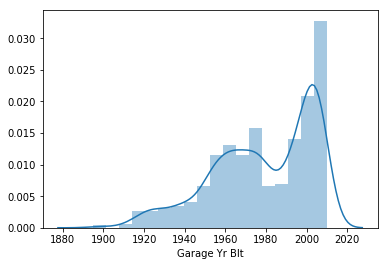

In [44]:
sns.distplot(df['Garage Yr Blt'][df['Garage Yr Blt'].notnull()])

The distribution is highly skewed to the left. I'm not sure what value to use, so I tested correlations below to see which made the value most meaningful.

In [45]:
np.corrcoef(df['Garage Yr Blt'][df['Garage Yr Blt'].notnull()], df['SalePrice'][df['Garage Yr Blt'].notnull()])

array([[1.        , 0.54132641],
       [0.54132641, 1.        ]])

In [46]:
temp = df['Garage Yr Blt'].fillna(0)
np.corrcoef(temp, df["SalePrice"])

array([[1.       , 0.2589456],
       [0.2589456, 1.       ]])

In [47]:
temp = df['Garage Yr Blt'].fillna(1895)
np.corrcoef(temp, df["SalePrice"])

array([[1.        , 0.55454692],
       [0.55454692, 1.        ]])

In [48]:
temp = df['Garage Yr Blt'].fillna(1920)
np.corrcoef(temp, df["SalePrice"])

array([[1.        , 0.57036925],
       [0.57036925, 1.        ]])

I will fill the null values with 1920, as this seems to be the lower end of the distribution, with only a few outliers below this value

In [49]:
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(1920)
test_data['Garage Yr Blt'] = test_data['Garage Yr Blt'].fillna(1920)

houses['Garage Yr Blt'] = houses['Garage Yr Blt'].fillna(1920)
houses_holdout['Garage Yr Blt'] = houses_holdout['Garage Yr Blt'].fillna(1920)

In [50]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage    330
dtype: int64

In [51]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage    160
dtype: int64

In [52]:
houses.isnull().sum()[houses.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage    330
dtype: int64

In [53]:
houses_holdout.isnull().sum()[houses_holdout.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage    160
dtype: int64

#### Predict Lot Frontage Values for missing info

Because there are many values missing for Lot Frontage, I will attempt to use the other data in the dataframes to predict what these values will be. If these predictions are more accurate than using the mean, then I will use them

In [54]:
target = 'Lot Frontage'
features = [col for col in df.columns if col != 'SalePrice' and col != target]

In [55]:
lot_holdout = df[df['Lot Frontage'].isnull()][features]
X_lot = df[df['Lot Frontage'].isnull() == False][features]
y_lot = df[df['Lot Frontage'].isnull() == False][target]

In [56]:
X_lot_train, X_lot_test, y_lot_train, y_lot_test = train_test_split(X_lot, y_lot, random_state=42, test_size=0.2)

ss_lot = StandardScaler()
X_lot_train_scaled = ss_lot.fit_transform(X_lot_train)
X_lot_test_scaled = ss_lot.transform(X_lot_test)

In [57]:
l1_ratios = np.linspace(0.1, 1.0, num=25)
e_net_lot = ElasticNetCV(l1_ratio=l1_ratios, cv=10, n_alphas=250, max_iter=2500)

e_net_scores = cross_val_score(e_net_lot, X_lot_train_scaled, y_lot_train, cv=10)
print('Elastic net cross-val scores:', e_net_scores.mean())

Elastic net cross-val scores: 0.551804483015703


In [58]:
lasso_lot = LassoCV(n_alphas = 500, cv=10)

lasso_scores = cross_val_score(lasso_lot, X_lot_train_scaled, y_lot_train)
print('Lasso cross-val scores:', lasso_scores.mean())

Lasso cross-val scores: 0.5840320437463197


In [59]:
lasso_lot.fit(X_lot_train_scaled, y_lot_train)
lasso_lot.score(X_lot_test_scaled, y_lot_test)

0.5569171980501832

In [60]:
e_net_lot.fit(X_lot_train_scaled, y_lot_train)
e_net_lot.score(X_lot_test_scaled, y_lot_test)

0.5786646847217743

In [61]:
lot_holdout_scaled = ss_lot.transform(lot_holdout)

In [62]:
lasso_lot_predictions = lasso_lot.predict(lot_holdout_scaled)
# e_net_lot_predictions = e_net_lot.predict(lot_holdout_scaled)

Because the lasso performed better on the test data, I will use these predictions to fill in the missing lot frontage values.

In [63]:
for i in df.index:
    if df['Lot Frontage'].isnull()[i]:
        df.loc[i, 'Lot Frontage'] = lasso_lot_predictions[list(lot_holdout.index).index(i)]

In [64]:
test_lot = test_data[test_data['Lot Frontage'].isnull()][features]
test_lot_scaled = ss_lot.transform(test_lot)
lasso_holdout_predictions = lasso_lot.predict(test_lot_scaled)

for i in test_data.index:
    if test_data['Lot Frontage'].isnull()[i]:
        test_data.loc[i, 'Lot Frontage'] = lasso_holdout_predictions[list(test_lot.index).index(i)]

In [65]:
test_data.isnull().sum().sum() + df.isnull().sum().sum()

0

In [66]:
houses['Lot Frontage'] = df['Lot Frontage']

In [67]:
houses_holdout['Lot Frontage'] = test_data['Lot Frontage']

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 2050
Columns: 262 entries, Id to Yr Sold_2010
dtypes: float64(11), int64(35), uint8(216)
memory usage: 1.2 MB


In [69]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Columns: 261 entries, Id to Yr Sold_2010
dtypes: float64(11), int64(34), uint8(216)
memory usage: 494.5 KB


Now there are no null values within the data. And all data is numeric

## Feature Engineering/Selection

Find which variables have the strongest correlation with Sale Price

In [70]:
df.corr().loc[:, 'SalePrice'].sort_values()

Garage Finish_Unf      -0.433129
Mas Vnr Type_None      -0.424512
Garage Type_Detchd     -0.369449
Foundation_CBlock      -0.356187
Lot Shape_Reg          -0.306704
Bsmt Exposure_No       -0.293522
Paved Drive_N          -0.273915
PID                    -0.255293
MS SubClass_30         -0.248799
Garage Finish_NA       -0.231243
Garage Type_NA         -0.231243
Sale Type_WD           -0.214881
Neighborhood_OldTown   -0.208617
Electrical_FuseA       -0.199599
House Style_1.5Fin     -0.196051
Exterior 1st_Wd Sdng   -0.191735
Neighborhood_IDOTRR    -0.189727
Neighborhood_NAmes     -0.189652
MS SubClass_50         -0.182567
Neighborhood_Edwards   -0.179408
Exterior 2nd_Wd Sdng   -0.173208
BsmtFin Type 1_NA      -0.160447
Alley_Grvl             -0.159288
BsmtFin Type 2_NA      -0.155051
Bsmt Exposure_NA       -0.153122
BsmtFin Type 1_Rec     -0.151113
Exterior 1st_MetalSd   -0.148547
Exterior 2nd_MetalSd   -0.139558
Enclosed Porch         -0.135516
Neighborhood_Sawyer    -0.133856
          

Find which variables have strong correlations with each other

In [71]:
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr = df.corr()

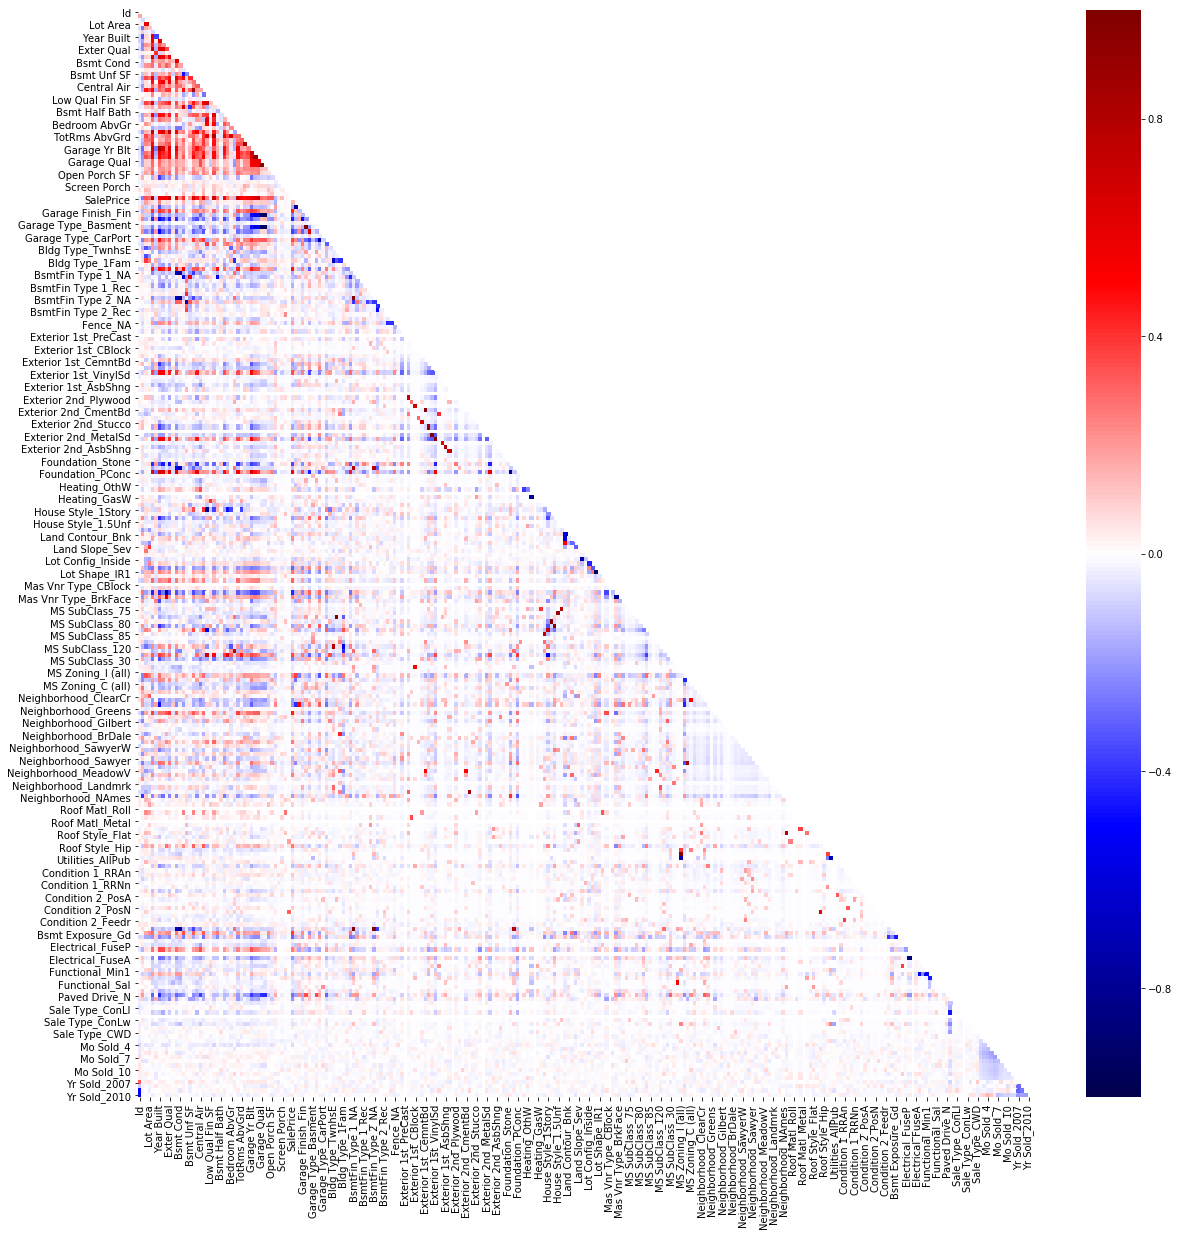

In [72]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, cmap='seismic', vmin=-1, vmax=1)

The above is way too much information, so instead I will create a pairplot of just the non-dummy features

In [73]:
non_dummy_cols = [col for col in df.columns if '_' not in col]
non_dummies = df[non_dummy_cols]
non_dummies.head()

Id        PID  Lot Frontage  Lot Area  Overall Qual  Overall Cond  \
0  109  533352170     50.470174     13517             6             8   
1  544  531379050     43.000000     11492             7             5   
2  153  535304180     68.000000      7922             5             7   
3  318  916386060     73.000000      9802             5             5   
4  255  906425045     82.000000     14235             6             8   

   Year Built  Year Remod/Add  Mas Vnr Area  Exter Qual    ...      \
0        1976            2005         289.0           4    ...       
1        1996            1997         132.0           4    ...       
2        1953            2007           0.0           3    ...       
3        2006            2007           0.0           3    ...       
4        1900            1993           0.0           3    ...       

   Garage Qual  Garage Cond  Wood Deck SF  Open Porch SF  Enclosed Porch  \
0            3            3             0             44               0   
1            3            3             0             74               0   
2            3            3             0             52               0   
3            3            3           100              0               0   
4            3            3             0             59               0   

   3Ssn Porch  Screen Porch  Pool Area  Misc Val  SalePrice  
0           0             0          0         0     130500  
1           0             0          0         0     220000  
2           0             0          0         0     109000  
3           0             0          0         0     174000  
4           0             0          0         0     138500  

[5 rows x 46 columns]

In [74]:
non_dummies.drop(['Id', 'PID'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [75]:
sns.pairplot(non_dummies)

Features with strong correlation with saleprice:
- `'Overall Qual'`
- `'Gr Liv Area'`
- `'Garage Area'`

# Step 4: Create Model

## Model 1: Overall Quality, Gr Liv Area, Garage Area

In [76]:
features_1 = ['Overall Qual', 'Gr Liv Area', 'Garage Area']

In [77]:
X1 = df[features_1]
y1 = df['SalePrice']

In [78]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

lr1 = LinearRegression()

kf1 = KFold(n_splits = 5, shuffle=True, random_state=8)

scores = cross_val_score(lr1, X1_train, y1_train, cv=kf1)
print(scores)
print(scores.mean())

[0.76936121 0.70866885 0.76699597 0.77570946 0.769754  ]
0.7580978985898124


In [79]:
lr1.fit(X1_train, y1_train)
lr1.score(X1_train, y1_train)

0.7646568617396425

In [80]:
lr1.score(X1_test, y1_test)

0.7178149552396913

In [82]:
X1_holdout = test_data[features_1]
predictions1 = lr1.predict(X1_holdout)

In [83]:
submission = pd.DataFrame(predictions1 ,index=test_data['Id'])

submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

SalePrice
Id                 
2658  197787.094472
2718  182906.923381
2414  202939.754293
1989  124391.674596
625   176754.942717

In [84]:
submission.to_csv('../Data/submission.csv')

The first model I made was just with those features that I identified as having the strongest correlations with sale price. This model performed terribly, and I quickly replaced it with a new one

## Model 2 - Model 1 + neighborhood dummies

In [ ]:
neighbor_dummies = pd.get_dummies(df, columns=['Neighborhood'], drop_first=True)

In [ ]:
neighborhoods = df['Neighborhood'].unique().tolist()

In [ ]:
# Check to see if there are differences in the average sale price and variance of sale price by neighborhoods
avg_sale = [df[df['Neighborhood'] == neighborhoods[i]]['SalePrice'].mean() for i in range(0, len(neighborhoods))]
nei_var = [df[df['Neighborhood'] == neighborhoods[i]]['SalePrice'].std() for i in range(0, len(neighborhoods))]
for i in range(len(avg_sale)):
    print(neighborhoods[i], avg_sale[i])
    print(neighborhoods[i], nei_var[i])

In [ ]:
dummies = [col for col in houses.columns if 'Neighborhood' in col]
type(dummies)

In [ ]:
features_2 = features

In [ ]:
features_2.extend(dummies)

In [ ]:
features_2

In [ ]:
X_2 = houses[features_2]

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y, test_size=0.2, random_state=8)

lr2 = LinearRegression()

kf2 = KFold(n_splits = 5, shuffle=True, random_state=8)

scores = cross_val_score(lr2, X2_train, y2_train, cv=kf2) 
print(scores) 
print(scores.mean())

In [ ]:
lr2.fit(X2_train, y2_train)

In [ ]:
lr2.score(X2_train, y2_train)

In [ ]:
lr2.score(X2_test, y2_test)

In [ ]:
X2_hold = test_data_copy[features_2]

In [ ]:
predictions2 = lr2.predict(X2_hold)

In [ ]:
submission2 = pd.DataFrame(predictions2, index = test_data['Id'])

In [ ]:
submission2.rename(columns={0:'SalePrice'}, inplace=True)
submission2.head()

In [ ]:
submission2.to_csv('../Data/submission.csv')

This model performed slightly better than the previous model, but still had a very large root mean squared error. After this, I decided to use way more information to make my model more accurate

## Model 3: Everything

In [ ]:
unused_cols = ['SalePrice', 'Id', 'PID']
features_3 = [col for col in df.columns if col not in unused_cols]
len(features_3)

In [ ]:
X3 = df[features_3]
y3 = df['SalePrice']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2)

In [ ]:
linreg3 = LinearRegression()

In [ ]:
ss3 = StandardScaler()

In [ ]:
X3_train_scaled = ss3.fit_transform(X3_train)
X3_test_scaled = ss3.transform(X3_test)

In [ ]:
cross_val_score(linreg3, X3_train_scaled, y3_train).mean()

### Lasso CV to cull features

Because the above model performed so poorly, I will regularize with LassoCV to get more accurate model

In [ ]:
lasso_cv3 = LassoCV(n_alphas = 1000, cv=10, max_iter=2500)

In [ ]:
scores3 = cross_val_score(lasso_cv3, X3_train_scaled, y3_train)
print(scores3)
print(scores3.mean())

In [ ]:
lasso_cv3.fit(X3_train_scaled, y3_train)

In [ ]:
lasso_cv3.score(X3_train_scaled, y3_train)

In [ ]:
lasso_cv3.score(X3_test_scaled, y3_test)

In [ ]:
lasso_cv3.alpha_

In [ ]:
mean_squared_error(y3_test, lasso_cv3.predict(X3_test_scaled))**0.5

In [ ]:
X3_holdout = test_data[features_3]
X3_holdout_scaled = ss3.transform(X3_holdout)

predictions3 = lasso_cv3.predict(X3_holdout_scaled)

submission3 = pd.DataFrame(predictions3,index=test_data['Id'])

submission3.rename(columns={0:'SalePrice'}, inplace=True)
submission3.head()

In [ ]:
submission3.to_csv('../Data/submission.csv')

### Model 4: run LassoCV on polynomial predictor matrix

The previous model performed well, but I can add interaction terms to make it perform better. I'll do this using polynomial features

In [ ]:
X4 = df[features_3]
y4 = df['SalePrice']

In [ ]:
X4.shape

In [ ]:
poly4 = PolynomialFeatures(include_bias=False)

In [ ]:
X4_poly = poly4.fit_transform(X4)

In [ ]:
X4_poly.shape

In [ ]:
X4_poly_train, X4_poly_test, y4_poly_train, y4_poly_test = train_test_split(X4_poly, y4, test_size=0.5)

In [ ]:
ss4 = StandardScaler()
X4_poly_train_scaled = ss4.fit_transform(X4_poly_train)
X4_poly_test_scaled = ss4.transform(X4_poly_test)

In [ ]:
lasso_poly4 = LassoCV(verbose=1, max_iter=200)

lp4_scores = cross_val_score(lasso_poly4, X4_poly_train_scaled, y4_poly_train)
print(lp4_scores)
print(lp4_scores.mean())

In [ ]:
lasso_poly4.fit(X4_poly_train_scaled, y4_poly_train)
lasso_poly4.score(X4_poly_test_scaled, y4_poly_test)

In [ ]:
X4_poly_train_scaled.shape, X4_poly_test_scaled.shape

In [ ]:
X4_hold = test_data[features_3]

X4_hold_poly = poly4.transform(X4_hold)
X4_hold_poly_scaled = ss4.transform(X4_hold_poly)

In [ ]:
poly_preds4 = lasso_poly4.predict(X4_hold_poly_scaled)

submission4 = pd.DataFrame(data=poly_preds4, index=test_data['Id'])
submission4.rename({0:'SalePrice'}, axis=1, inplace=True)

submission4.to_csv('../Data/submission.csv')

Try the same thing using the `houses` and `houses_holdout`

In [ ]:
unused_cols = ['SalePrice', 'Id', 'PID']
features_5 = [col for col in houses.columns if col not in unused_cols]

X5 = houses[features_5]
y5 = houses['SalePrice']

In [ ]:
poly5 = PolynomialFeatures(include_bias=False)

In [ ]:
X5_poly = poly5.fit_transform(X5)

In [ ]:
X5_poly_train, X5_poly_test, y5_poly_train, y5_poly_test = train_test_split(X5_poly, y5, test_size=0.2)

In [ ]:
ss5 = StandardScaler()
X5_poly_train_scaled = ss5.fit_transform(X5_poly_train)
X5_poly_test_scaled = ss5.transform(X5_poly_test)

In [ ]:
lasso_poly5 = LassoCV(verbose=1, max_iter=2000)

lp5_scores = cross_val_score(lasso_poly5, X5_poly_train_scaled, y5_poly_train)
print(lp5_scores)
print(lp5_scores.mean())

In [ ]:
X5_hold = houses_holdout[features_5]

X5_hold_poly = poly5.transform(X5_hold)
X5_hold_poly_scaled = ss5.transform(X5_hold_poly)

In [ ]:
lasso_poly5.fit(X5_poly_train_scaled, y5_poly_train)
lasso_poly5.score(X5_poly_test_scaled, y5_poly_test)

In [ ]:
poly_preds5 = lasso_poly5.predict(X5_hold_poly_scaled)

submission5 = pd.DataFrame(data=poly_preds5, index=test_data['Id'])
submission5.rename({0:'SalePrice'}, axis=1, inplace=True)

submission5.to_csv('../Data/submission.csv')

# Alternate Approach: Selective Interaction Features

Instead of using all of the interaction features and creating an extremely large model, I can instead select those interaction features which are most meaningful. Below, I write functions to identify interaction features based on different criteria

In [ ]:
def best_degree_2_interactions(df1, target, num, df2, df3):
    '''
    Find the second degree interaction terms from df1 that have the strongest correlation with SalePrice.
    Will find {num} interaction terms with strongest correlations, and append those interaction terms to
    all 3 dataframes passed as inputs.
    '''
    interactions = []
    correlations = []
    
    for col in df1.columns:
        for col2 in df1.columns:
            
            # Find correlations between interaction term and sale price
            corr = np.corrcoef(df1[col] * df1[col2], target)[0][1]
            
            # Always add first correlation term
            if correlations == []:
                correlations.append(corr)
                interactions.append([col, col2])
                
            # Check if correlation is stronger than minimum in list
            if abs(corr) > min(correlations):
                
                # Check if correlation already in list by alphabetizing feature names
                temp = [min([col, col2]), max([col, col2])]
                if temp in interactions:
                    continue
                
                # Add correlation value to correlation list, add interaction term name to
                # interactions list
                correlations.append(abs(corr))
                interactions.append(temp)
                
                # If there are too many correlations, remove weakest correlation and 
                # corresponding interaction term from appropriate list
                if len(correlations) > num:
                    del interactions[correlations.index(min(correlations))]
                    correlations.remove(min(correlations))
    
    # Append all interaction terms to all three dataframes
    for item in interactions:
        name = "*".join(item)
        df1[name] = df1[item[0]]*df1[item[1]]
        df2[name] = df2[item[0]]*df2[item[1]]
        df3[name] = df3[item[0]]*df3[item[1]]
    return None
    

In [ ]:
def best_interaction_finder (df1, str_list, target, df_list):
    '''
    Finds the best interaction terms between 3 and 5 degrees for columns that contain any of the 
    strings in str_list. Defines best interaction term by correlation coefficient with sale price.
    Appends interaction term to all dataframes passed as input.
    '''
    
    # Find all columns that contain strings from str_list
    cols = []
    for feat in str_list:
        cols.extend(col_finder(df1, feat))
    
    # Exclude any interaction terms already in dataframe
    cols = [a for a in cols if '*' not in a]
    
    # Set baseline values
    best_r2 = 0
    feature_combo = None
    series = None
    
    # End function if fewer than 3 columns found to make interaction terms with
    if len(cols) < 2:
        print('Only {} columns found'.format(len(cols)))
        return None
    if len(cols) == 2:
        print('Only 2 colums found. Only returning Interaction and R2 score, not adding to DF')
        corr = np.corrcoef(df1[cols[0]]*df1[cols[1]], target)[0][1]
        name = '*'.join(cols)
        print(corr, name)
        return None
    
    # Find all combinations between 3 degrees and either length of column list or 5, whatever is lower
    max_combo_size= min([len(cols), 5])
    for r in range(3, max_combo_size):
        for combo in itertools.combinations(cols, r):
            
            # Make list of appropriate series
            temp = [df1[item] for item in list(combo)]
            
            # Create interaction term by multiplying all series
            interaction = reduce(lambda x, y: x*y, temp)
            
            # Check correlation coefficient. If better than current best, update values to return
            corr = np.corrcoef(interaction, target)[0][1]
            if abs(corr) > best_r2:
                best_r2 = abs(corr)
                feature_combo = list(combo)
                series = interaction
    # 
    df1['*'.join(feature_combo)] = series
    for frame in df_list:
        temp_frame = [frame[item] for item in feature_combo]
        temp_interact = reduce(lambda x, y: x*y, temp_frame)
        frame['*'.join(feature_combo)] = temp_interact
    return (best_r2, '*'.join(feature_combo))

In [ ]:
features_int = [col for col in df.columns if col not in ['Id', 'PID', 'SalePrice']]
X_inter = df[features_int]
y = df['SalePrice']

X_inter_train, X_inter_test, y_inter_train, y_inter_test = train_test_split(X_inter, y, test_size=0.2)

X_inter_holdout = test_data[features_int]

In [ ]:
interactions_list = [
    ['Garage'], ['Bsmt'], ['Qual'], ['Area'], ['Garage', 'Qual'], ['Area', 'Qual'],
    ['Porch', 'Deck', 'Lot'], ['Year', 'Yr'], ['Kitchen'], ['Gr']
]
for item in interactions_list:
    best_interaction_finder(X_inter_train, item, y_inter_train, [X_inter_test, X_inter_holdout])

In [ ]:
ss_inter = StandardScaler()

ss.fit(X_inter_train)
X_inter_train_scaled = ss.transform(X_inter_train)
X_inter_test_scaled = ss.transform(X_inter_test)
X_inter_holdout_scaled = ss.transform(X_inter_holdout)

In [ ]:
lasso_inter = LassoCV()

li_scores = cross_val_score(lasso_inter, X_inter_train_scaled, y_inter_train)
print(li_scores)
print(li_scores.mean())

In [ ]:
ridge_inter = RidgeCV()

ri_scores = cross_val_score(ridge_inter, X_inter_train_scaled, y_inter_train)
print(ri_scores)
print(ri_scores.mean())

In [ ]:
lasso_inter.fit(X_inter_train_scaled, y_inter_train)
lasso_inter.score(X_inter_test_scaled, y_inter_test)

In [ ]:
ridge_inter.fit(X_inter_train_scaled, y_inter_train)
ridge_inter.score(X_inter_test_scaled, y_inter_test)

In [ ]:
li_preds = lasso_inter.predict(X_inter_holdout_scaled)
ri_preds = ridge_inter.predict(X_inter_holdout_scaled)

In [ ]:
submission = pd.DataFrame(data=li_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [ ]:
submission = pd.DataFrame(data=ri_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [ ]:
def strong_2d_interactions (df1, target, df_list, strength=0.7):
    for combo in itertools.combinations(df1.columns, 2):
        cols = list(combo)
        interaction = df1[cols[0]]*df1[cols[1]]
        corr = np.corrcoef(interaction, target)[0][1]
        if abs(corr) > strength:
            df1['*'.join(cols)] = interaction
            for frame in df_list:
                f_interact = frame[cols[0]] * frame[cols[1]]
                frame['*'.join(cols)] = f_interact
    return None

In [ ]:
features_int = [col for col in df.columns if col not in ['Id', 'PID', 'SalePrice']]
X_inter = df[features_int]
y = df['SalePrice']

X_inter_train, X_inter_test, y_inter_train, y_inter_test = train_test_split(X_inter, y, test_size=0.2)

X_inter_holdout = test_data[features_int]

In [ ]:
strong_2d_interactions(X_inter_train, y_inter_train, [X_inter_test, X_inter_holdout], strength=0.6)

In [ ]:
interactions_list = [
    ['Garage'], ['Qual'], ['Area', 'Room'], ['Garage', 'Qual'], ['Area', 'Qual'],
    ['Porch', 'Deck', 'Lot'], ['Year', 'Yr'], ['Kitchen'], ['Gr'], ['SF', 'Qual'],
    ['Type', 'Qual']
]
for item in interactions_list:
    best_interaction_finder(X_inter_train, item, y_inter_train, [X_inter_test, X_inter_holdout])

In [ ]:
ss = StandardScaler()

X_inter_train_scaled = ss.fit_transform(X_inter_train)
X_inter_test_scaled = ss.transform(X_inter_test)
X_inter_holdout_scaled = ss.transform(X_inter_holdout)

In [ ]:
lasso_inter = LassoCV(n_alphas = 500, max_iter=1500, cv=5)

li_scores = cross_val_score(lasso_inter, X_inter_train_scaled, y_inter_train)
print(li_scores)
print(li_scores.mean())

In [ ]:
lasso_train_score = lasso_inter.score(X_inter_train_scaled, y_inter_train)

In [ ]:
lasso_inter.fit(X_inter_train_scaled, y_inter_train)
lasso_test_score = lasso_inter.score(X_inter_test_scaled, y_inter_test)

In [ ]:
lasso_coefs = pd.DataFrame(lasso_inter.coef_, index=X_inter_train.columns)
abs_lasso_coefs = lasso_coefs[0].map(lambda cell: abs(cell))
pos_values = abs_lasso_coefs.sort_values(0, ascending=False).head(10).values
pos_labels = abs_lasso_coefs.sort_values(0, ascending=False).head(10).index

In [ ]:
pos_values

In [ ]:
degree = [2, 2, 2, 2, 4, 2, 4, 2, 2, 2]

In [ ]:
plt.figure(figsize=(10,10))
plt.barh(range(1, 11), pos_values)
plt.yticks(range(1, 11), pos_labels, size=15)
plt.title('Largest Lasso Coefficients', position=(0,1), size=20, ha='left')
ax=plt.gca()
ax.get_children()[9].set_color('purple')


In [ ]:
lasso_coefs.sort_values(0, ascending=False).tail(10)

In [ ]:
lasso_single_coefs = [col for col in list(lasso_coefs.index) if '*' not in col]


In [ ]:
lasso_coefs.loc[lasso_single_coefs,:].sort_values(0, ascending=False).head()

In [ ]:
li_preds = lasso_inter.predict(X_inter_holdout_scaled)
submission = pd.DataFrame(data=li_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [ ]:
alpha = np.logspace(0, 5, 100)
ridge_inter = RidgeCV(alphas = alpha, cv=10)

ri_scores = cross_val_score(ridge_inter, X_inter_train_scaled, y_inter_train)
print(ri_scores)
print(ri_scores.mean())

In [ ]:
ridge_inter.fit(X_inter_train_scaled, y_inter_train)
ridge_train_score = ridge_inter.score(X_inter_train_scaled, y_inter_train)
ridge_test_score = ridge_inter.score(X_inter_test_scaled, y_inter_test)

In [ ]:
ridge_inter.alpha_

In [ ]:
ri_preds = ridge_inter.predict(X_inter_holdout_scaled)
submission = pd.DataFrame(data=ri_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [ ]:
l1_ratios = np.linspace(0.1, 1.0, 50)
en = ElasticNetCV(l1_ratio = l1_ratios, n_alphas = 500, cv=5)

en_scores = cross_val_score(en, X_inter_train_scaled, y_inter_train)
print(en_scores)
print(en_scores.mean())

In [ ]:
en.fit(X_inter_train_scaled, y_inter_train)
en_train_score = en.score(X_inter_train_scaled, y_inter_train)
en_test_score = en.score(X_inter_test_scaled, y_inter_test)

In [ ]:
en_preds = en.predict(X_inter_holdout_scaled)
submission = pd.DataFrame(data=en_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [ ]:
train_scores = [en_train_score, lasso_train_score, ridge_train_score]
test_scores = [en_test_score, lasso_test_score, ridge_test_score]
score_dif = [train_scores[i] - test_scores[i] for i in range(0, 3)]

In [ ]:
ridge_train_score

In [ ]:
plt.figure(figsize=(10,5))
plt.bar([1, 2, 3], train_scores)
plt.bar([1,2,3], test_scores)
plt.xticks([1, 2, 3], ['Elastic Net', 'Lasso', 'Ridge'], size=20)
plt.ylim((0.9, 0.98))
plt.title("Train and Test R2 Scores", position=(0,1), size=20, ha='left')
ax = plt.gca()
for i in range(1, 4):
    ax.text(i, train_scores[i-1] +.001, str(round(train_scores[i-1]*100, 2))+'%', size=15, ha='center')
    ax.text(i, test_scores[i-1]-.01, str(round(test_scores[i-1]*100, 2))+'%', size=15, ha='center')